In [635]:
import numpy as np
import pandas as pd
from scipy.stats import norm

In [1009]:
def transmat():
    transmat = np.array([[0.9, 0.1],[0.1, 0.9]])
    return transmat

In [1010]:
def emissions():
    emissions = np.array([ np.ones(6)/6, np.ones(6)/10])
    emissions[1][5] = 1/2
    return emissions

In [1011]:
t = transmat()
e = emissions()

In [1012]:
def viterbi(x, transmat, emissions):
    v_seq = np.zeros((len(x), len(transmat)))
    states = np.zeros((len(x), len(transmat)))
    best_states = np.zeros(len(x),  dtype=int)
    for i in range(len(v_seq)):
        if i == 0:
            v_seq[0] = (1/len(transmat)) * emissions[:,x[i]]
            states[0] = np.array([-1, -1])
            continue
        p = v_seq[i-1] * transmat.T
        states[i] =  np.argmax(p, axis=1)
        v_seq[i] =   emissions[:,x[i]] * np.amax(p, axis = 1)
        
    best_states[-1] = np.argmax(v_seq[-1])
    
    for i in reversed(range(1, len(x))):
        best_states[i-1] = states[i][best_states[i]]
        
    return v_seq, states, best_states
    

# Forward Algorithm

\begin{equation}
\label{eq:bayes}
f_{(k)}(i) =  P(X_{1}....X_{i} |\Pi_{i} = k)
\end{equation}

In [1013]:
def forward(x, transmat, emissions):
    f_seq = np.zeros((len(x), len(transmat)))
    for i in range(len(f_seq)):
        if i == 0:
            f_seq[i] =  emissions[:,x[i]] * (1/len(transmat))
            continue
        f_seq[i] = emissions[:,x[i]] * np.matmul(f_seq[i-1], transmat)
        
    P = (1/len(transmat))*sum(f_seq[-1])
        
    return (f_seq, P)

# Backward Algorithm

\begin{equation}
\label{eq:bayes}
B_{(k)}(i) =  P(X_{i+1}....X_{L} |\Pi_{i} = k)
\end{equation}

In [1014]:
def backward(x, transmat, emissions):
    b_seq = np.zeros((len(x), len(transmat)))
    for i in reversed(range(len(b_seq))):
        if i == len(b_seq) -1:
            b_seq[i] =  (1/len(transmat))*np.ones(len(transmat))
            continue
        b_seq[i] = np.matmul(emissions[:,x[i+1]] * b_seq[i+1],  transmat.T)
    
    P = (1/len(transmat))*sum(emissions[:,x[0]] * b_seq[0])
    return (b_seq, P)

In [1015]:
x = np.array([1,0, 5, 1,5, 5,3, 5, 5, 1, 2,3, 4, 5, 5, 5,0, 2, 3, 4 ,5, 5, 5, 1, 5, 5, 4, 5, 1, 2, 0, 4, 5, 1, 5, 1, 0,1, 1, 2, 3, 4, 5, 5, 2, 0, 2, 3, 1, 1, 5, 5, 5, 5,5 ,5
             ,5,3,5,5,5,0,5,5,5,5,5,2,5,5,2, 1,5,5,5,0,5,1,2,3,1,1,0,1,1,0,1,1,1,1,2,2,2,2,2,2,4,3,2,3,4,1,5,1,5,0,2,3,4,5])

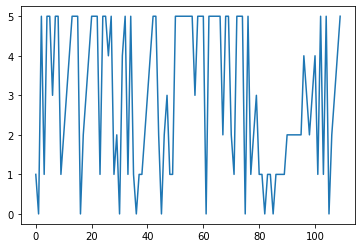

In [1016]:
plt.plot(range(len(x)),x)

In [1017]:
v, states, path = viterbi(x, t, e)

In [1018]:
f, P1 = forward(x,t,e)

In [1019]:
b, P2 = backward(x,t,e)

# Let's plot posterior probabilities

\begin{equation}
\label{eq:bayes}
P(\pi(i) = k|\textbf{X}) =  \frac{P(X_{1}....X_{i} |\Pi_{i} = k) P(X_{i+1}....X_{L} |\Pi_{i} = k)}{P(\textbf{X})} 
\end{equation}

## Which is just:

\begin{equation}
\label{eq:bayes}
P(\pi(i) = k|\textbf{X}) =  \frac{f_{(k)}(i) B_{(k)}(i)}{P(\textbf{X})} 
\end{equation}

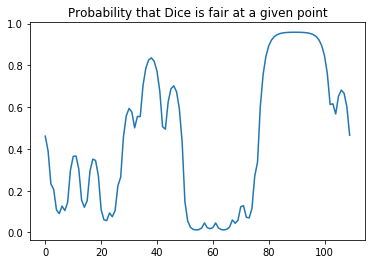

In [1020]:
import matplotlib.pyplot as plt
plt.title('Probability that Dice is fair at a given point')
plt.plot(f[:, 0]*b[:,0]/P1)
plt.show()


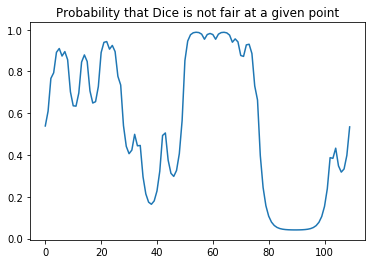

In [1021]:
import matplotlib.pyplot as plt
plt.title('Probability that Dice is not fair at a given point')
plt.plot(f[:, 1]*b[:,1]/P1)



plt.show()

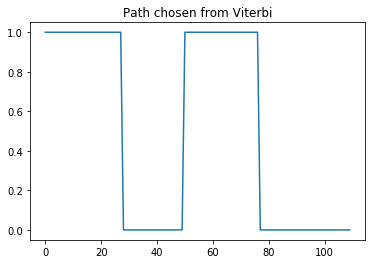

In [1022]:
plt.title('Path chosen from Viterbi')
plt.plot(path)

In [1023]:
file_name = '/pollard/home/lchumpitaz/Hi-C/GM12878_inSitu_MboI.hg19.mapq_30_1.csv'

In [1024]:
df = pd.read_csv(file_name)

In [1025]:
filtered_df= df[df['E1'] == df['E1']]

In [1026]:
loc_eig = filtered_df[filtered_df['chrom'] == 'chr1']

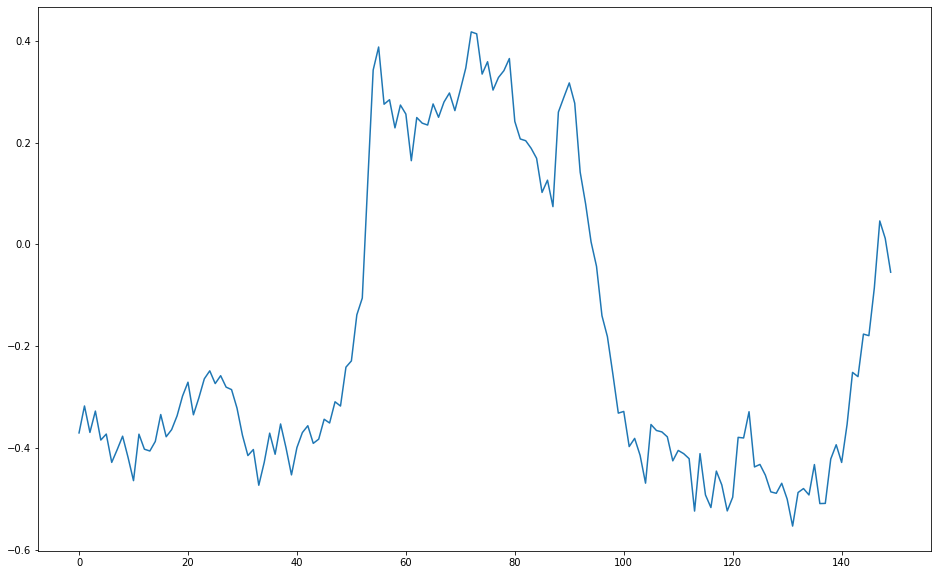

In [1267]:
fig = plt.figure(figsize=(16, 10)) 
data = loc_eig['E1'].values[6000:6150]
plt.plot(np.round(data, 10))

In [1258]:
w_data = np.round(data, 2)

In [1259]:
middle = np.percentile(w_data, [20, 80])

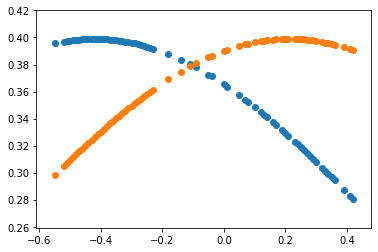

In [1260]:
rv1 = norm(loc = middle[0], scale = 1)
rv2 = norm(loc = middle[1], scale = 1)

x = np.unique(w_data)
e1 = rv1.pdf(x)
e2 = rv2.pdf(x)
#plot the pdfs of these normal distributions 
plt.scatter( x, e1)
plt.scatter(x, e2)

In [1261]:
emissions = np.array([e1/sum(e1), e2/sum(e2)])

In [1262]:
index_dict = dict()
for i in range(len(x)):
    index_dict[x[i]] = i

In [1263]:
seq = np.array([index_dict[element] for element in w_data])

In [1264]:
v, states, path = viterbi(seq, t, emissions)

In [1265]:
f, P1 = forward(seq, t, emissions)
b, P2 = backward(seq, t, emissions)

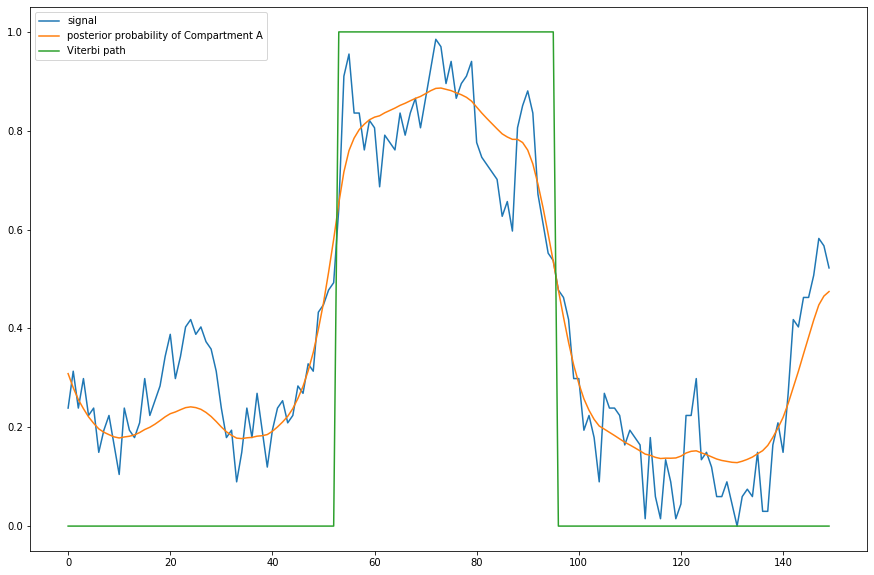

In [1266]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10)) 
plt.plot(seq/len(emissions[0]), label = 'signal')
plt.plot(f[:, 1]*b[:,1]/P1, label = 'posterior probability of Compartment A')
plt.plot(path, label = 'Viterbi path')

plt.legend(loc='upper left')
plt.show()
